In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

import tqdm
import bvcopula
from vine import CVine

In [2]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
path_models = f"{conf.path2outputs}/{exp_pref}"

In [3]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [4]:
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]

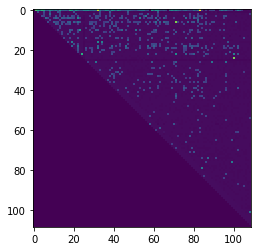

In [5]:
plt.imshow(WAICs[:])

In [6]:
device = "cuda:1"

# create linspace
N_points = 50
train_x = torch.linspace(0,1,N_points).to(device)

copula_layers, likelihood_layers, fs_layers = [], [], []
for layer in tqdm.tqdm(range(0,NN-1)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    copulas, liks, fs = [], [], []
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            liks.append(model.likelihood)
            with torch.no_grad():
                f = model(train_x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                fs.append(f)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
            fs.append(None)
            liks.append([bvcopula.IndependenceCopula_Likelihood()])
    copula_layers.append(copulas)
    likelihood_layers.append(liks)
    fs_layers.append(fs)

100%|██████████| 108/108 [00:07<00:00, 14.31it/s]


In [7]:
# import time
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
# indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                     torch.ones(1,1,device=device),
#                     [bvcopula.IndependenceCopula])
# N = Y.shape[-1]
# device = torch.device('cpu')
# data_layers = [torch.tensor(Y).float().to(device)]
# copula_layers = []
# t0 = time.time()
# for m in range(0,N-1):
#     copulas, layer = [], []
#     for n in tqdm.tqdm(range(1,N-m)):
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = likelihood_layers[m][n-1]
#         f0 = fs_layers[m][n-1]
#         if f0 is None:
#             assert likelihood[0].name=='Independence'
#             copulas.append(indep)
#             layer.append(samples[:,0])
#         else:
#             f0 = f0.mean(axis=-1).unsqueeze(-1)
# #             copula0 = likelihood(f0)
#             copula = likelihood.fit(samples,f0)
# #             print(f"{m},{n+m}: {(copula0.theta-copula.theta).mean().cpu()}")
#             copulas.append(copula)
#             layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)
# t1= time.time()
# print(f"{(t1-t0)//60}")

In [7]:
vine = CVine(copula_layers,train_x,device=device)

In [10]:
%time Hrs = vine.entropy(sem_tol=.1, mc_size=4000, v=True)
Hrs

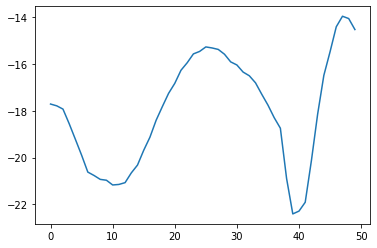

In [10]:
plt.plot(Hrs.cpu().numpy())

In [26]:
# vine_trained = CVine(copula_layers,torch.ones(1),device=device)
# with open(f"{home}/results/vine_unconditional.pkl","wb") as f:
#     pkl.dump(vine_trained,f)
with open(f"{home}/results/vine_unconditional.pkl","rb") as f:
    vine_trained = pkl.load(f)
# %time Hr = vine_trained.entropy(sem_tol=.1, mc_size=4000, v=True)

In [12]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
for n in tqdm.tqdm(range(NN-1)):
    vine = CVine(copula_layers[n:],train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(-entropy.mean().item())
    vine = CVine(uncond_layers[n:],torch.ones(1),device='cpu')
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(-entropy.mean().item())
    print(Hrs[-1]-Hr[-1])

  1%|          | 1/108 [03:36<6:26:56, 216.98s/it]

-9.15621566772461


  2%|▏         | 2/108 [04:15<4:48:56, 163.55s/it]

-4.5488691329956055


  3%|▎         | 3/108 [04:53<3:40:21, 125.92s/it]

-4.459320068359375


  4%|▎         | 4/108 [05:26<2:49:38, 97.87s/it] 

-4.277570724487305


  5%|▍         | 5/108 [05:51<2:10:41, 76.14s/it]

-3.330451011657715


  6%|▌         | 6/108 [06:16<1:42:59, 60.58s/it]

-2.8351964950561523


  6%|▋         | 7/108 [06:39<1:23:25, 49.56s/it]

-2.994633674621582


  7%|▋         | 8/108 [06:58<1:07:01, 40.21s/it]

-1.7636184692382812


  8%|▊         | 9/108 [07:16<55:14, 33.48s/it]  

-1.6857671737670898


  9%|▉         | 10/108 [07:33<46:47, 28.65s/it]

-1.488358974456787


 10%|█         | 11/108 [07:50<40:39, 25.15s/it]

-1.4202995300292969


 11%|█         | 12/108 [08:06<35:59, 22.50s/it]

-1.5080180168151855


 12%|█▏        | 13/108 [08:22<32:26, 20.49s/it]

-1.538008689880371


 13%|█▎        | 14/108 [08:38<29:43, 18.98s/it]

-1.5322599411010742


 14%|█▍        | 15/108 [08:53<27:38, 17.84s/it]

-1.5893831253051758


 15%|█▍        | 16/108 [09:07<25:51, 16.87s/it]

-1.5607233047485352


 16%|█▌        | 17/108 [09:22<24:25, 16.10s/it]

-1.5605673789978027


 17%|█▋        | 18/108 [09:36<23:10, 15.45s/it]

-1.4570879936218262


 18%|█▊        | 19/108 [09:45<20:24, 13.75s/it]

-1.4867162704467773


 19%|█▊        | 20/108 [09:52<16:57, 11.56s/it]

-1.5360541343688965


 19%|█▉        | 21/108 [09:58<14:22,  9.92s/it]

-0.7242326736450195


 20%|██        | 22/108 [10:04<12:29,  8.71s/it]

-0.7475626468658447


 21%|██▏       | 23/108 [10:10<11:04,  7.82s/it]

-0.8206825256347656


 22%|██▏       | 24/108 [10:15<09:58,  7.12s/it]

-0.04122328758239746


 23%|██▎       | 25/108 [10:20<09:08,  6.61s/it]

-0.1367201805114746


 24%|██▍       | 26/108 [10:26<08:28,  6.20s/it]

-0.7706942558288574


 25%|██▌       | 27/108 [10:31<07:56,  5.89s/it]

-0.7792593240737915


 26%|██▌       | 28/108 [10:36<07:28,  5.60s/it]

-0.7455071210861206


 27%|██▋       | 29/108 [10:41<07:04,  5.37s/it]

-0.8105887174606323


 28%|██▊       | 30/108 [10:45<06:43,  5.18s/it]

-0.7241986989974976


 29%|██▊       | 31/108 [10:50<06:25,  5.00s/it]

-0.679327130317688


 30%|██▉       | 32/108 [10:54<06:07,  4.83s/it]

-0.671262264251709


 31%|███       | 33/108 [10:59<05:50,  4.68s/it]

-0.6718194484710693


 31%|███▏      | 34/108 [11:03<05:34,  4.52s/it]

-0.6646432876586914


 32%|███▏      | 35/108 [11:07<05:18,  4.36s/it]

-0.46733760833740234


 33%|███▎      | 36/108 [11:11<05:03,  4.22s/it]

-0.5472630262374878


 34%|███▍      | 37/108 [11:14<04:49,  4.08s/it]

-0.5300546884536743


 35%|███▌      | 38/108 [11:18<04:34,  3.92s/it]

-0.4938020706176758


 36%|███▌      | 39/108 [11:21<04:20,  3.78s/it]

-0.5564788579940796


 37%|███▋      | 40/108 [11:25<04:07,  3.65s/it]

-0.5439424514770508


 38%|███▊      | 41/108 [11:28<03:54,  3.50s/it]

-0.4939839243888855


 39%|███▉      | 42/108 [11:31<03:41,  3.36s/it]

-0.4240623712539673


 40%|███▉      | 43/108 [11:34<03:29,  3.23s/it]

-0.42504632472991943


 41%|████      | 44/108 [11:37<03:19,  3.11s/it]

-0.43579989671707153


 42%|████▏     | 45/108 [11:39<03:08,  2.99s/it]

-0.39694464206695557


 43%|████▎     | 46/108 [11:42<02:58,  2.88s/it]

-0.31280988454818726


 44%|████▎     | 47/108 [11:45<02:49,  2.78s/it]

-0.35356801748275757


 44%|████▍     | 48/108 [11:47<02:40,  2.68s/it]

-0.33356261253356934


 45%|████▌     | 49/108 [11:49<02:32,  2.59s/it]

-0.30283021926879883


 46%|████▋     | 50/108 [11:52<02:25,  2.50s/it]

-0.31227150559425354


 47%|████▋     | 51/108 [11:54<02:17,  2.42s/it]

-0.3128616213798523


 48%|████▊     | 52/108 [11:56<02:11,  2.34s/it]

-0.3370780050754547


 49%|████▉     | 53/108 [11:58<02:04,  2.26s/it]

-0.3549281358718872


 50%|█████     | 54/108 [12:00<01:58,  2.19s/it]

-0.29846611618995667


 51%|█████     | 55/108 [12:02<01:51,  2.11s/it]

-0.31094056367874146


 52%|█████▏    | 56/108 [12:04<01:45,  2.03s/it]

-0.3305261433124542


 53%|█████▎    | 57/108 [12:06<01:39,  1.96s/it]

-0.3167439103126526


 54%|█████▎    | 58/108 [12:08<01:34,  1.89s/it]

-0.3363685607910156


 55%|█████▍    | 59/108 [12:09<01:29,  1.82s/it]

-0.2630741596221924


 56%|█████▌    | 60/108 [12:11<01:24,  1.75s/it]

-0.263227254152298


 56%|█████▋    | 61/108 [12:12<01:19,  1.68s/it]

-0.2597172260284424


 57%|█████▋    | 62/108 [12:14<01:14,  1.61s/it]

-0.21817031502723694


 58%|█████▊    | 63/108 [12:15<01:09,  1.54s/it]

-0.21404987573623657


 59%|█████▉    | 64/108 [12:16<01:04,  1.48s/it]

-0.17595458030700684


 60%|██████    | 65/108 [12:18<01:00,  1.41s/it]

-0.18389788269996643


 61%|██████    | 66/108 [12:19<00:56,  1.35s/it]

-0.20333006978034973


 62%|██████▏   | 67/108 [12:20<00:52,  1.29s/it]

-0.17514804005622864


 63%|██████▎   | 68/108 [12:21<00:49,  1.23s/it]

-0.15786121785640717


 64%|██████▍   | 69/108 [12:22<00:45,  1.17s/it]

-0.11238020658493042


 65%|██████▍   | 70/108 [12:23<00:42,  1.12s/it]

-0.06696026027202606


 66%|██████▌   | 71/108 [12:24<00:39,  1.06s/it]

-0.1158759742975235


 67%|██████▋   | 72/108 [12:25<00:36,  1.01s/it]

-0.13548339903354645


 68%|██████▊   | 73/108 [12:26<00:33,  1.05it/s]

-0.024796441197395325


 69%|██████▊   | 74/108 [12:27<00:30,  1.11it/s]

-0.041763365268707275


 69%|██████▉   | 75/108 [12:27<00:28,  1.17it/s]

-0.033585041761398315


 70%|███████   | 76/108 [12:28<00:25,  1.24it/s]

-0.04787328094244003


 71%|███████▏  | 77/108 [12:29<00:23,  1.32it/s]

-0.03180309385061264


 72%|███████▏  | 78/108 [12:29<00:21,  1.41it/s]

-0.041358813643455505


 73%|███████▎  | 79/108 [12:30<00:19,  1.51it/s]

-0.05257347971200943


 74%|███████▍  | 80/108 [12:30<00:17,  1.61it/s]

-0.058257848024368286


 75%|███████▌  | 81/108 [12:31<00:15,  1.73it/s]

-0.047670893371105194


 76%|███████▌  | 82/108 [12:31<00:14,  1.85it/s]

-0.0500711053609848


 77%|███████▋  | 83/108 [12:32<00:12,  1.98it/s]

-0.0575886070728302


 78%|███████▊  | 84/108 [12:32<00:11,  2.13it/s]

-0.04093889147043228


 79%|███████▊  | 85/108 [12:32<00:10,  2.30it/s]

-0.042041242122650146


 80%|███████▉  | 86/108 [12:33<00:08,  2.50it/s]

-0.01860370859503746


 81%|████████  | 87/108 [12:33<00:07,  2.71it/s]

-0.021385882049798965


 81%|████████▏ | 88/108 [12:33<00:06,  2.94it/s]

-0.03155229613184929


 82%|████████▏ | 89/108 [12:34<00:05,  3.22it/s]

-0.007579149678349495


 84%|████████▍ | 91/108 [12:34<00:04,  3.93it/s]

-0.009369481354951859
-0.012308354489505291


 86%|████████▌ | 93/108 [12:34<00:03,  4.81it/s]

-0.011701634153723717
-0.014862236566841602


 88%|████████▊ | 95/108 [12:35<00:02,  5.94it/s]

-0.01622184831649065
-0.019394012168049812


 91%|█████████ | 98/108 [12:35<00:01,  7.55it/s]

-0.031346472911536694
-0.012473998591303825
-0.013462222181260586


 95%|█████████▌| 103/108 [12:35<00:00, 11.00it/s]

-0.011573312804102898
-0.019092713482677937
-0.017226919531822205
-0.021712826564908028
0.0
0.0


100%|██████████| 108/108 [12:35<00:00,  7.00s/it]

0.0
0.0
0.0
0.0


In [ ]:
# mem = (Hrs, Hr)
# with open(f"{home}/results/Hrs_and_Hr_experimental.pkl","wb") as f:
#     pkl.dump((Hrs,Hr),f)
with open(f"{home}/results/singleH.pkl","wb") as f: #single variable BI_KSG:(MI,H(Y|X)) from standard data
    pkl.dump(singleH,f)

In [126]:
with open(f"{home}/results/Hrs_and_Hr_experimental.pkl","rb") as f:
    (Hrs,Hr) = pkl.load(f)
np.array(Hrs)[0]

18.035791397094727

In [135]:
n=3
layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
layers

[[MixtureCopula(theta: torch.Size([2, 50]), mix: torch.Size([2, 50])),
  MixtureCopula(theta: torch.Size([2, 50]), mix: torch.Size([2, 50])),
  MixtureCopula(theta: torch.Size([2, 50]), mix: torch.Size([2, 50]))],
 [MixtureCopula(theta: torch.Size([2, 50]), mix: torch.Size([2, 50])),
  MixtureCopula(theta: torch.Size([1, 0]), mix: torch.Size([1, 50]))],
 [MixtureCopula(theta: torch.Size([1, 0]), mix: torch.Size([1, 50]))]]

In [137]:
HRS = []
for n in tqdm.tqdm(range(20)):
    layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
    vine = CVine(layers,train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    HRS.append(-entropy.mean().item())



  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:00<00:00, 36.25it/s]

 35%|███▌      | 7/20 [00:00<00:00, 21.79it/s]

 45%|████▌     | 9/20 [00:00<00:01, 10.44it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.03it/s]

 55%|█████▌    | 11/20 [00:01<00:02,  4.40it/s]

 60%|██████    | 12/20 [00:01<00:02,  3.44it/s]

 65%|██████▌   | 13/20 [00:02<00:02,  2.80it/s]

 70%|███████   | 14/20 [00:03<00:03,  1.92it/s]

 75%|███████▌  | 15/20 [00:04<00:03,  1.49it/s]

 80%|████████  | 16/20 [00:05<00:03,  1.24it/s]

 85%|████████▌ | 17/20 [00:06<00:02,  1.08it/s]

 90%|█████████ | 18/20 [00:07<00:02,  1.05s/it]

 95%|█████████▌| 19/20 [00:09<00:01,  1.18s/it]

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


In [88]:
import MI
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
# %time KSG = MI.Mixed_KSG(X,Y)
# KSG

In [90]:
singleH = np.empty((Y.shape[-1],2))
for i in range(Y.shape[-1]):
    singleH[i,:] = MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,i].reshape((*X.shape,1)))

In [138]:
# np.sum(singleH)
# np.sum(allH)#np.sum(singleH)
HRS

[-0.0,
 0.4998270273208618,
 0.9397875666618347,
 1.2119992971420288,
 1.4415050745010376,
 1.8783982992172241,
 1.977783203125,
 2.0854430198669434,
 2.5893940925598145,
 2.887439727783203,
 2.985644817352295,
 3.1160600185394287,
 3.299564838409424,
 3.7173571586608887,
 3.9001903533935547,
 4.04926872253418,
 4.214621543884277,
 4.419668674468994,
 4.536856174468994,
 4.620572566986084]

In [120]:
allH = []
for n in range(1,20):
    allH.append(MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,:n])[1])

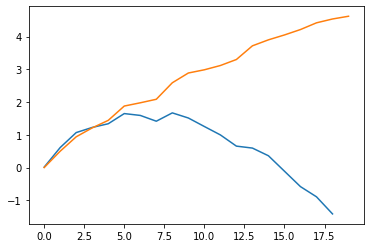

In [140]:
plt.plot([-a for a in allH])
plt.plot(HRS)

[ 1.80357914e+01  1.00874043e+01  9.68608379e+00  9.50804901e+00
  8.59898376e+00  8.08220577e+00  7.92550659e+00  7.32173920e+00
  6.95403957e+00  6.42730713e+00  6.35233879e+00  5.33967161e+00
  5.14609385e+00  5.04538918e+00  4.98054028e+00  4.65625858e+00
  4.59846258e+00  4.56145763e+00  4.34786797e+00  4.15962982e+00
  3.31099272e+00  3.20633483e+00  3.07397628e+00  2.66247272e+00
  2.65676451e+00  2.00692201e+00  1.99954951e+00  1.90863097e+00
  1.89004600e+00  1.82639039e+00  1.76264465e+00  1.72223735e+00
  1.63303947e+00  1.51497293e+00  1.31970048e+00  1.27761805e+00
  1.23699880e+00  1.04305482e+00  1.04575288e+00  1.00379896e+00
  8.00116122e-01  6.74734950e-01  6.01392269e-01  5.91812551e-01
  5.38460970e-01  5.13077378e-01  5.13240874e-01  5.03321648e-01
  5.01758695e-01  4.94169801e-01  4.92427588e-01  4.85016137e-01
  4.77643073e-01  4.55890328e-01  4.40766871e-01  4.31721479e-01
  3.97580445e-01  3.99148047e-01  3.29721212e-01  3.31668049e-01
  3.22824478e-01  3.10799

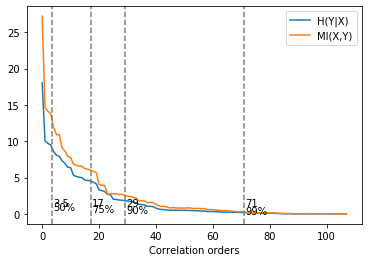

In [142]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
# plt.plot(Hr/Hr[0])
plt.plot(Hrs, label="H(Y|X)")
plt.plot(Hr, label="MI(X,Y)")
# plt.axhline(0.01,c='black',linestyle='dashed')
plt.axvline(3.5,c='grey',linestyle='dashed')
plt.axvline(17,c='grey',linestyle='dashed')
plt.axvline(29,c='grey',linestyle='dashed')
plt.axvline(71,c='grey',linestyle='dashed')
plt.text(3.8,1.0,'3.5')
plt.text(17.5,1.0,'17')
plt.text(29.5,1.0,'29')
plt.text(71.5,1.0,'71');
plt.text(3.8,0.5,'50%')
plt.text(17.5,0.25,'75%')
plt.text(29.5,0.11,'90%')
plt.text(71.5,0.02,'99%');
plt.xlabel('Correlation orders')
plt.legend()

In [27]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
vineC = CVine(copula_layers,train_x,device=device)
vineU = CVine(uncond_layers,torch.ones(1),device='cpu')
for n in tqdm.tqdm([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108]):
    entropy = vineC.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(entropy.mean().item())
    entropy = vineU.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(entropy.mean().item())
    print(Hrs[-1]-Hr[-1])

  5%|▌         | 1/19 [03:30<1:03:07, 210.41s/it]

9.179655075073242


 11%|█         | 2/19 [07:06<1:00:05, 212.07s/it]

9.087356567382812


 16%|█▌        | 3/19 [10:29<55:50, 209.42s/it]  

9.030080795288086


 21%|██        | 4/19 [14:04<52:46, 211.07s/it]

9.030542373657227


 26%|██▋       | 5/19 [17:25<48:32, 208.02s/it]

8.977790832519531


 32%|███▏      | 6/19 [20:57<45:19, 209.21s/it]

8.91030502319336


 37%|███▋      | 7/19 [24:27<41:53, 209.42s/it]

8.960779190063477


 42%|████▏     | 8/19 [27:45<37:46, 206.06s/it]

8.83676528930664


 47%|████▋     | 9/19 [31:01<33:51, 203.15s/it]

8.614717483520508


 53%|█████▎    | 10/19 [33:57<29:14, 194.95s/it]

7.879853248596191


 58%|█████▊    | 11/19 [36:32<24:23, 183.00s/it]

7.901966094970703


 63%|██████▎   | 12/19 [39:04<20:15, 173.70s/it]

7.670048713684082


 68%|██████▊   | 13/19 [41:25<16:23, 163.91s/it]

6.641422271728516


 74%|███████▎  | 14/19 [43:45<13:02, 156.50s/it]

6.6919355392456055


 79%|███████▉  | 15/19 [45:55<09:54, 148.59s/it]

6.217408180236816


 84%|████████▍ | 16/19 [47:57<07:01, 140.67s/it]

5.190773010253906


 89%|████████▉ | 17/19 [49:57<04:28, 134.49s/it]

5.246406555175781


 95%|█████████▍| 18/19 [51:55<02:09, 129.54s/it]

5.0725812911987305


100%|██████████| 19/19 [52:02<00:00, 164.33s/it]

0.0


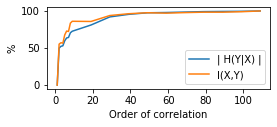

In [50]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
plt.figure(figsize=(4,1.5))
ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
plt.plot(ns,100*Hr/Hr[0], label='| H(Y|X) |')
# plt.plot(ns,Hrs/Hrs[0])
plt.plot(ns,100*(Hrs-Hr)/(Hrs[0]-Hr[0]),label='I(X,Y)')
plt.xlabel('Order of correlation')
plt.ylabel('%')
plt.legend()
# plt.axhline(0.01,c='black',linestyle='dashed')

In [7]:
conditional_model = copula_layers[0][31]
theta0 = conditional_model.theta.mean(axis=-1)
mix0 = conditional_model.mix.mean(axis=-1)
copula = bvcopula.MixtureCopula(theta0,mix0,conditional_model.copulas,rotations=conditional_model.rotations)
copula.entropy()

tensor(-0.0266)

In [8]:
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
samples = torch.tensor(Y[:,[0,32]]).float().to(theta0.device)

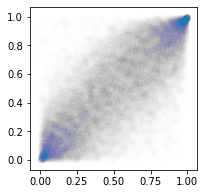

In [9]:
plt.figure(figsize=(3,3))
plt.scatter(*Y[:,[0,2]].T,alpha=0.005)

In [10]:
f0 = fs_layers[0][31].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][31]
likelihood(f0).mix, mix0

(tensor([[0.6428],
         [0.1772],
         [0.1800]]), tensor([0.6082, 0.2148, 0.1770]))

In [11]:
samples = torch.tensor(Y[:,[0,33]]).float().to(device)
f0 = fs_layers[0][32].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][32].to(device)
%time copula = likelihood.fit(samples,f0)
# %time copula, plot_loss = train(samples)

CPU times: user 10.2 s, sys: 184 ms, total: 10.4 s
Wall time: 5.55 s


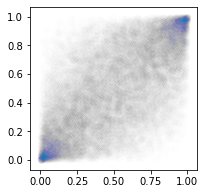

In [290]:
plt.figure(figsize=(3,3))
plt.scatter(*copula.sample(torch.Size([20000])).cpu().numpy().T,alpha=0.005)

In [9]:
samples = vine.sample(torch.Size([100]))

In [111]:
indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula])
truncated_layers = [[model for model in layer] for layer in copula_layers]
Ncut = (NN-3)-1
for i in range(1,Ncut+1):
    for j in range(i):
        truncated_layers[-i][j] = indep
vine = CVine(truncated_layers,train_x,device=device)

In [112]:
entropy2 = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

tensor(1.1057, device='cuda:1')


In [116]:
entropy2.mean()/entropy.mean()

tensor(0.5101, device='cuda:1')

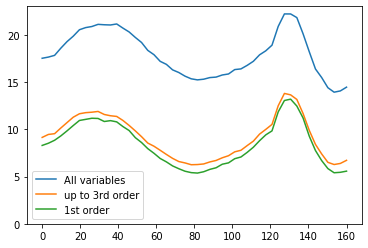

In [118]:
x = np.linspace(0,160,N_points)
plt.plot(x,-entropy.cpu().numpy(), label="All variables")
plt.plot(x,-entropy2.cpu().numpy(), label="up to 3rd order")
plt.plot(x,-entropy3.cpu().numpy(), label="1st order")
plt.ylim(0,23)
plt.legend();

Text(0, 0.5, 'Entropy')

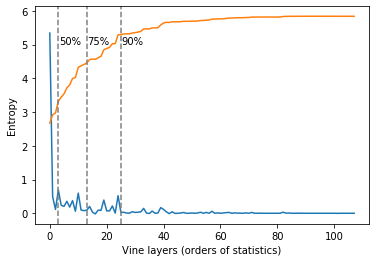

In [17]:
np_repeats = np.array(repeats)
H_layers = np_repeats.mean(axis=0)[::-1]
plt.plot(H_layers)
plt.plot(H_layers.cumsum()/2)
plt.axvline(3,color='grey',linestyle='dashed')
plt.axvline(13,color='grey',linestyle='dashed')
plt.axvline(25,color='grey',linestyle='dashed')
plt.text(3.2,5,'50%')
plt.text(13.2,5,'75%')
plt.text(25.2,5,'90%')
plt.xlabel('Vine layers (orders of statistics)')
plt.ylabel('Entropy')

In [ ]:
H_layers[0].sum()/H_layers.sum()

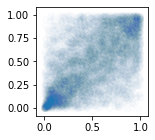

In [65]:
plt.figure(figsize=(2,2))
layer0 = layers[-1]
plt.scatter(layer0[0],layer0[3],alpha=0.01)

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(samples[...,0].cpu().numpy(),new_samples[...,-1].cpu().numpy(),alpha=0.01)

In [12]:
def generate_samples(samples,NN):
    layers = []
    for layer in torch.arange(NN-1,0):
        # load models for a layer
        with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
            results = pkl.load(f)
        # assign memory for a new layer samples
        new_layer_shape = torch.Size([N_points])+sample_size+torch.Size([NN-1-layer])
        new_samples = torch.empty(size=new_layer_shape, device=device)
        # transfrom samples
        transform(X,layers[-1],new_samples,layer,results)
        # store the result
        layers.append(new_samples.clone())
    return layers
%time samples = generate_samples(samples,NN)

CPU times: user 2min 8s, sys: 529 ms, total: 2min 8s
Wall time: 13.6 s


In [13]:
len(samples)

109